# Pipeline Iris

In [48]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import bhrdj

### Load data

In [2]:
from sklearn.datasets import load_iris
X = pd.DataFrame(load_iris().data, columns=load_iris().feature_names)
y = (pd.Series(load_iris().target, name='species')
       .replace({i:j for i,j in enumerate(load_iris().target_names)}))
df = pd.concat((y,X), axis=1)

### EDA

#### Sort features by univariate knn accuracy 

In [56]:
# %psource bhrdj.score_func_knn

In [51]:
from sklearn.feature_selection import SelectKBest

In [50]:
skb = SelectKBest(k=2, score_func=bhrdj.score_func_knn)
fa = skb.fit(X,y) # feature accuracies
feats_scored = pd.Series(fa.scores_, index=fa.feature_names_in_, name=fa.score_func).sort_values(ascending=False)
feats_scored

petal width (cm)     0.960000
petal length (cm)    0.953333
sepal length (cm)    0.726667
sepal width (cm)     0.553333
Name: <function score_func_knn at 0x7f4e4141d4c0>, dtype: float64

In [52]:
X = X.reindex(columns=feats_scored.index)

#### plot univariate kernel density estimates (smoothed histograms)

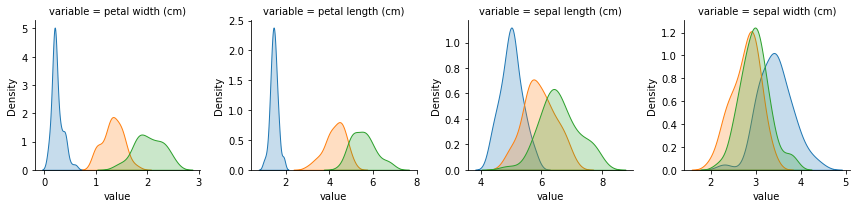

In [53]:
g = sns.FacetGrid(X.join(y).melt(id_vars=y.name), 
                  col="variable", col_wrap=4, sharex=False, sharey=False, 
                  hue=y.name)
g.map(sns.kdeplot, "value", fill=True)
plt.show()

#### plot 2d histograms

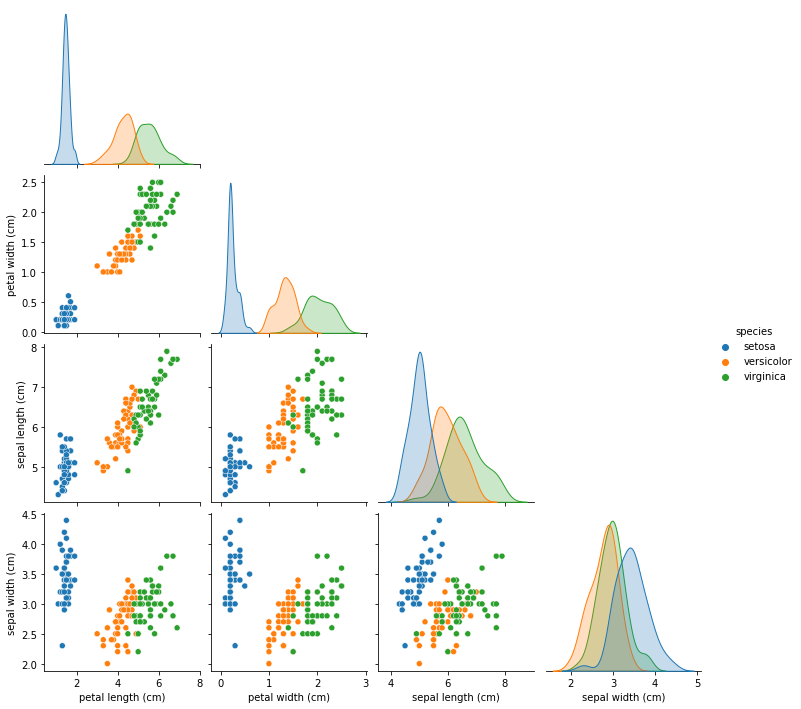

In [7]:
sns.pairplot(df, 
             x_vars=sorted(load_iris().feature_names), 
             y_vars=sorted(load_iris().feature_names), 
             hue='species',
             corner=True)
plt.show()

### Analyze

In [15]:
Xtr,Xte,ytr,yte = train_test_split(X, y, test_size=.2, random_state=0)

In [44]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.svm import SVC

In [36]:
scaler = StandardScaler()
pca = PCA()
svc = SVC()
sfs = SequentialFeatureSelector(svc)

In [38]:
pipelines = {}
pipelines['svc_only'] = Pipeline([('scaler', scaler), ('svc', svc)])
pipelines['sfs_svc'] = Pipeline([('scaler', scaler), ('sfs', sfs), ('svc', svc)])
pipelines['eigens_svc'] = Pipeline([('scaler', scaler), ('eigens', pca), ('svc', svc)])
pipelines['eigens_sfs_svc'] = Pipeline([('scaler', scaler), ('eigens', pca), ('sfs', sfs), ('svc', svc)])

In [41]:
for pipe in pipelines:
    pipelines[pipe].fit(Xtr,ytr)
    print(f'{pipe}: '
          f"n features is {pipelines[pipe].named_steps['svc'].n_features_in_}, "
          f'score is {pipelines[pipe].score(Xte,yte)}, ')

svc_only: n features is 4, score is 1.0, 
sfs_svc: n features is 2, score is 0.9666666666666667, 
eigens_svc: n features is 4, score is 1.0, 
eigens_sfs_svc: n features is 2, score is 1.0, 


In [19]:
preds = pd.Series(pipe.predict(Xte), index=Xte.index, name='preds1')
pd.concat((preds, yte), axis=1);

###

In [42]:
from sklearn.metrics import confusion_matrix

In [20]:
confusion_matrix(preds, yte)

array([[11,  0,  0],
       [ 0, 13,  0],
       [ 0,  0,  6]])